In [63]:
import os
import re
import subprocess
from typing import List, Optional, Dict, Any, TypedDict

from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

load_dotenv()

True

In [64]:
# --- Step 1: Define State (Revised) ---
class PortScanState(TypedDict):
    target_ip: str
    scan_intent: str
    llm_command_raw: Optional[str]
    validated_command: Optional[str] # For the initial fast scan
    scan_output: Optional[str] # Output of the initial fast scan
    open_ports: List[int] # All open ports from the initial scan

    # For detailed web scan
    web_ports_identified: List[int] # Ports identified as web-related from open_ports
    detailed_web_scan_command: Optional[str] # Single nmap command for web ports
    detailed_web_scan_output: Optional[str] # Output of the detailed web scan
    web_service_details: Optional[List[Dict[str, str]]] # Parsed port, service, version

    error_message: Optional[str]

In [65]:
# --- Step 2: LLM and Prompt Setup (Revised) ---
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

FAST_SCAN_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     "You are a penetration tester and Nmap expert. Based on the user's scan intent and IP, generate a fast Nmap command. "
     "Use options like -T4 -Pn for speed. If the user's intent suggests needing service information for decisions (like identifying web ports later), "
     "consider adding a light service detection like -sV --version-light or ensuring service names are part of the output. " # 서비스 탐지 격려 문구 추가
     "Do NOT include anything except the raw command. "
     "It must begin with 'nmap' and target the given IP."
     "Do not add complex pipeline, just needs simple nmap command."),
    ("human", "Target: {target_ip}\nIntent: {scan_intent}")
])

DETAILED_WEB_SCAN_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     "You are a penetration tester. Based on the target IP and a list of identified web-related open ports, "
     "generate a SINGLE Nmap command for deeper analysis of these web services. "
     "The command should target all provided web ports in one go (e.g., using -p port1,port2,port3). "
     "Use script scanning and version detection (e.g., -sCV or -sV --script=http-*) suitable for web services. "
     "Only output the raw Nmap command, starting with 'nmap'. Do not add any explanation or extra text."),
    ("human", "Target IP: {target_ip}\nWeb Ports: {web_ports_str}")
])

IDENTIFY_WEB_PORTS_LLM_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     "You are an expert system that identifies web-related ports based on Nmap scan findings. "
     "Given a list of open ports and their detected services from an Nmap scan (format: 'PORT/PROTOCOL: SERVICE_NAME'), "
     "identify which of these ports are likely hosting web services (e.g., HTTP, HTTPS, HTTP proxies, web application servers, admin panels, APIs over HTTP/S). "
     "Consider both standard (e.g., 80, 443) and non-standard ports if their service names suggest web functionality (e.g., 'http-alt', 'webcache', a service name containing 'tomcat', 'jetty', 'nginx-http', 'http-proxy', 'nagios-nsca', 'www', 'ssl', 'soap', 'rest'). "
     "If a service name is generic (e.g., 'tcpwrapped', 'unknown', 'disc-cisco') but the port is a very common web port (e.g. 80, 443, 8000, 8080, 8443), lean towards classifying it as web-related. "
     "Output ONLY a comma-separated list of port numbers that you identify as web-related. If no ports are identified as web-related, output an empty string or the word 'None'. "
     "Do not include any other explanation or text in your response."),
    ("human", "Here are the open ports and their detected services:\n{port_service_list_str}\n\nWhich of these are web-related ports? Output only the comma-separated port numbers.")
])

fast_scan_chain = FAST_SCAN_PROMPT | llm | StrOutputParser()
detailed_web_scan_chain = DETAILED_WEB_SCAN_PROMPT | llm | StrOutputParser()
identify_web_ports_llm_chain = IDENTIFY_WEB_PORTS_LLM_PROMPT | llm | StrOutputParser() # 새로운 체인

In [66]:
# --- Step 3: Node Definitions (Revised and New) ---

def generate_scan_command(state: PortScanState) -> PortScanState:
    print("🔧 Generating fast scan command...")
    cmd = fast_scan_chain.invoke({
        "target_ip": state["target_ip"],
        "scan_intent": state["scan_intent"]
    })
    return {"llm_command_raw": cmd.strip(), "error_message": None}

In [67]:
def validate_command(state: PortScanState) -> PortScanState:
    print("🔒 Validating generated command...")
    cmd = state.get("llm_command_raw", "").strip()
    target_ip = state["target_ip"]

    if not cmd:
        return {"error_message": "No command generated."}
    if not cmd.startswith("nmap"):
        return {"error_message": "Invalid command (does not start with nmap)"}
    
    # Stricter validation for forbidden characters/patterns
    # This aims to prevent command injection if shell=True is used,
    # though ideally shell=False with shlex.split is safer if possible.
    forbidden_patterns = [";", "&&", "||", ">", "<", "`", "$(", " rm ", "sudo ", "mv ", "cp ", "chmod ", "chown "]
    if any(pattern in cmd for pattern in forbidden_patterns):
        return {"error_message": "Command contains forbidden characters or patterns."}
    
    # Ensure target IP is part of the command arguments, not just anywhere
    # This regex is a basic attempt to find the IP as a standalone argument.
    if not re.search(r'\s' + re.escape(target_ip) + r'(\s|$)', cmd) and not cmd.endswith(target_ip):
         # Check if it's at the very end, e.g., "nmap -T4 127.0.0.1"
        if not cmd.split()[-1] == target_ip:
             return {"error_message": f"Target IP {target_ip} not found as a distinct argument in command: '{cmd}'"}

    return {"validated_command": cmd, "error_message": None}

In [68]:
def execute_scan(state: PortScanState) -> PortScanState:
    print(f"🚀 Executing initial scan: {state['validated_command']}")
    try:
        # Using shell=True with validated command. Ensure validation is robust.
        # Consider shlex.split(state["validated_command"]) and shell=False if feasible
        # but nmap sometimes benefits from shell interpretation for complex flag combinations.
        output = subprocess.check_output(
            state["validated_command"], 
            shell=True, 
            text=True, 
            timeout=60,
            stderr=subprocess.STDOUT # Capture stderr too
        )
        return {"scan_output": output, "error_message": None}
    except subprocess.TimeoutExpired:
        print("Initial scan timed out.")
        return {"scan_output": "Error: Initial scan timed out.", "error_message": "Initial scan timed out."}
    except subprocess.CalledProcessError as e:
        print(f"Initial scan failed with CalledProcessError: {e.output}")
        return {"scan_output": e.output, "error_message": f"Initial scan command failed: {e.output}"}
    except Exception as e:
        print(f"Initial scan failed with an unexpected error: {str(e)}")
        return {"scan_output": f"Error: {str(e)}", "error_message": f"Initial scan failed: {str(e)}"}


In [69]:
def parse_open_ports(state: PortScanState) -> PortScanState:
    print("🧠 Parsing open ports from initial scan...")
    output = state.get("scan_output", "")
    ports = set()

    if "Host seems down" in output:
        print("Host seems down. No open ports found.")
        # Keep existing error_message if one was set by execute_scan timeout/failure
        current_error = state.get("error_message")
        return {
            "open_ports": [], 
            "web_ports_identified": [], 
            "error_message": current_error if current_error else "Host seems down according to Nmap."
        }

    for line in output.splitlines():
        match = re.match(r"(\d+)/tcp\s+open", line) # Focusing on TCP ports
        if match:
            ports.add(int(match.group(1)))
    
    sorted_ports = sorted(list(ports))
    print(f"Found open TCP ports: {sorted_ports}" if sorted_ports else "No open TCP ports found in scan output.")

    if not sorted_ports and not state.get("error_message"):
        if "All ports scanned on" in output and ("are in ignored states" in output or "are closed" in output or "are filtered" in output):
            print("No open ports found (all scanned ports are closed/filtered).")
            # This is not an error state, just no open ports.

    return {"open_ports": sorted_ports, "error_message": state.get("error_message")}


In [70]:
def identify_web_related_ports(state: Dict) -> Dict: # Changed PortScanState to Dict for broader compatibility if TypedDict is not fully defined here
    print("🤖 Using LLM to identify web-related ports from scan_output...")
    open_ports_numbers: List[int] = state.get("open_ports", [])
    scan_output: Optional[str] = state.get("scan_output", "")

    if not open_ports_numbers:
        print("No open ports to analyze for web services.")
        return {"web_ports_identified": [], "error_message": state.get("error_message")}

    if not scan_output:
        print("No scan output available to identify web services. Falling back to common web port numbers for open ports.")
        # Fallback logic: if scan_output is missing, use common_web_ports heuristic (optional)
        common_web_ports = [80, 443, 3000, 5000, 8000, 8008, 8080, 8888, 8443, 9000, 9090]
        identified_fallback = sorted([port for port in open_ports_numbers if port in common_web_ports])
        print(f"Fallback: Identified web ports using heuristics: {identified_fallback}")
        return {"web_ports_identified": identified_fallback, "error_message": state.get("error_message")}

    # Extract port and service information for open_ports_numbers from scan_output
    # Example: "80/tcp   open  http", "22/tcp   open  ssh"
    port_service_map: Dict[int, str] = {}
    for line in scan_output.splitlines():
        # Regex: attempts to capture port, protocol, state, service name, and (optional) version info
        match = re.match(r"(\d+)/(tcp|udp)\s+open\s+([\w\-\/?\.%]+)\s*(.*)", line)
        if match:
            port_num_str, protocol, service_name = match.groups()[:3]
            try:
                port_num = int(port_num_str)
                if port_num in open_ports_numbers: # Process only confirmed open ports
                    port_service_map[port_num] = f"{port_num_str}/{protocol}: {service_name}"
            except ValueError:
                print(f"Warning: Could not parse port number from '{port_num_str}'")


    if not port_service_map:
        print("Could not extract service information for open ports from scan_output. LLM might rely on port numbers only if it proceeds.")
        # If no service info, LLM might infer from port numbers or use a default list.
        # Here, we'll pass a list of open ports with "unknown" service.
        port_service_list_str = "\n".join([f"{p}/tcp: unknown" for p in open_ports_numbers])
        if not port_service_list_str: # Handles edge case of empty open_ports_numbers
             print("No open ports or service information to pass to LLM.")
             return {"web_ports_identified": [], "error_message": state.get("error_message")}
    else:
        port_service_list_str = "\n".join(port_service_map.values())
        print(f"Passing the following to LLM for web port identification:\n{port_service_list_str}")

    identified_web_ports_llm: List[int] = []
    try:
        # This assumes identify_web_ports_llm_chain is defined and executable
        if 'identify_web_ports_llm_chain' in globals() and identify_web_ports_llm_chain is not None:
            llm_response: str = identify_web_ports_llm_chain.invoke({"port_service_list_str": port_service_list_str})
            print(f"LLM response for web ports: '{llm_response}'")

            if not llm_response or llm_response.strip().lower() == 'none' or not llm_response.strip():
                identified_web_ports_llm = []
            else:
                # Convert comma-separated port number string to integer list
                # Add exception handling: in case LLM returns non-numeric values
                for p_str in llm_response.split(','):
                    p_str_cleaned = p_str.strip()
                    if p_str_cleaned.isdigit():
                        port_candidate = int(p_str_cleaned)
                        if port_candidate in open_ports_numbers: # Ensure LLM-returned port is actually an open port
                            identified_web_ports_llm.append(port_candidate)
                        else:
                            print(f"Warning: LLM suggested port {port_candidate}, which was not in the list of confirmed open ports. Ignoring.")
                    elif p_str_cleaned: # Non-numeric and not empty (malformed response)
                         print(f"Warning: LLM returned non-numeric port value '{p_str_cleaned}'. Ignoring.")
                identified_web_ports_llm = sorted(list(set(identified_web_ports_llm))) # Remove duplicates and sort
        else:
            print("Error: 'identify_web_ports_llm_chain' is not defined. Cannot perform LLM-based identification.")
            raise NameError("'identify_web_ports_llm_chain' not defined")


    except Exception as e:
        print(f"Error during LLM call for web port identification: {str(e)}")
        # Fallback logic on LLM call failure (e.g., use heuristics or return empty list)
        common_web_ports_fallback = [80, 443, 8000, 8080] # More conservative fallback
        identified_web_ports_llm = sorted([p for p in open_ports_numbers if p in common_web_ports_fallback])
        print(f"Using fallback heuristics due to LLM error: {identified_web_ports_llm}")
        # Optionally, record the error in the state:
        # state["error_message"] = f"LLM web port identification failed: {str(e)}" # Be careful about overwriting existing errors

    if identified_web_ports_llm:
        print(f"LLM identified web-related ports: {identified_web_ports_llm}")
    else:
        print("LLM did not identify any web-related ports from the provided list.")

    return {"web_ports_identified": identified_web_ports_llm, "error_message": state.get("error_message")}

In [71]:
# def identify_web_related_ports(state: PortScanState) -> PortScanState:
#     print("🕸️ Identifying web-related ports...")
#     open_ports = state.get("open_ports", [])
#     if not open_ports:
#         print("No open ports to analyze for web services.")
#         return {"web_ports_identified": [], "error_message": state.get("error_message")}

#     common_web_ports = [80, 443, 3000, 5000, 8000, 8008, 8080, 8888, 8443, 9000, 9090]
#     identified_web_ports = sorted([port for port in open_ports if port in common_web_ports])
    
#     if identified_web_portidentify_web_related_portss:
#         print(f"Identified common web-related ports: {identified_web_ports}")
#     else:
#         print("No common web-related ports found among open ports.")

#     return {"web_ports_identified": identified_web_ports, "error_message": state.get("error_message")}


In [72]:
def generate_detailed_web_scan_command(state: PortScanState) -> PortScanState:
    print("📜 Generating detailed web scan command...")
    web_ports = state.get("web_ports_identified", [])
    target_ip = state["target_ip"]

    if not web_ports:
        print("No web ports identified for detailed scan. Skipping command generation.")
        return {"detailed_web_scan_command": None, "error_message": state.get("error_message")}

    web_ports_str = ",".join(map(str, web_ports))
    print(f"Requesting detailed command for IP: {target_ip}, Web Ports: {web_ports_str}")
    
    try:
        cmd = detailed_web_scan_chain.invoke({
            "target_ip": target_ip,
            "web_ports_str": web_ports_str
        })
    except Exception as e:
        print(f"LLM call for detailed command failed: {str(e)}")
        return {"error_message": f"LLM call for detailed command failed: {str(e)}"}

    validated_cmd = cmd.strip()
    if not validated_cmd.startswith("nmap"):
        err_msg = f"LLM generated invalid detailed command (doesn't start with nmap): {validated_cmd}"
        print(err_msg)
        return {"error_message": err_msg}
    if target_ip not in validated_cmd:
        err_msg = f"LLM generated detailed command missing target IP ({target_ip}): {validated_cmd}"
        print(err_msg)
        return {"error_message": err_msg}
    
    # Check if generated command includes the intended ports (basic check)
    for port_str in web_ports_str.split(','):
        if port_str not in validated_cmd:
            print(f"Warning: Port {port_str} not found in generated command '{validated_cmd}'. LLM might use ranges or wildcards.")
            # This is a warning, not necessarily an error if LLM uses other ways to specify ports.

    print(f"Generated detailed web scan command: {validated_cmd}")
    return {"detailed_web_scan_command": validated_cmd, "error_message": None}

In [73]:
def execute_detailed_web_scan(state: PortScanState) -> PortScanState:
    command = state.get("detailed_web_scan_command")
    if not command:
        print("⚪ No detailed web scan command to execute.")
        return {"detailed_web_scan_output": None, "error_message": state.get("error_message")}

    print(f"🚀 Executing detailed web scan: {command}")
    try:
        output = subprocess.check_output(
            command, 
            shell=True, 
            text=True, 
            timeout=180, # Longer timeout for detailed scans
            stderr=subprocess.STDOUT
        )
        return {"detailed_web_scan_output": output, "error_message": None}
    except subprocess.TimeoutExpired:
        print("Detailed web scan timed out.")
        return {"detailed_web_scan_output": "Error: Detailed scan timed out.", "error_message": "Detailed web scan timed out."}
    except subprocess.CalledProcessError as e:
        print(f"Detailed web scan failed with CalledProcessError: {e.output}")
        return {"detailed_web_scan_output": e.output, "error_message": f"Detailed web scan command failed: {e.output}"}
    except Exception as e:
        print(f"Detailed web scan failed with an unexpected error: {str(e)}")
        return {"detailed_web_scan_output": f"Error: {str(e)}", "error_message": f"Detailed web scan failed: {str(e)}"}


In [74]:
def parse_web_service_details(state: PortScanState) -> PortScanState:
    print("🔍 Parsing detailed web scan results for service versions...")
    output = state.get("detailed_web_scan_output", "")
    if not output or "Error:" in output[:100]: # Basic check if output itself is an error message
        print("No valid detailed scan output to parse or output indicates an error.")
        return {"web_service_details": [], "error_message": state.get("error_message")}

    services_found = []
    # Regex: captures port, protocol (usually tcp), state (must be open), service, and the rest as version.
    # Example line: 80/tcp   open  http    Apache httpd 2.4.52 ((Ubuntu))
    # Example line: 443/tcp  open  ssl/http Apache httpd 2.4.52 ((Ubuntu))
    # Example line: 8080/tcp open  http-proxy Squid http proxy 4.13
    # Example line with script output for version:
    # 8000/tcp open  http    Python SimpleHTTPServer
    # | http-server-header: SimpleHTTP/0.6 Python/3.10.12
    # The main regex captures the primary service line.
    # We filter for http-related services.
    
    # Regex to find lines like "PORT/PROTOCOL STATE SERVICE VERSION"
    # (\d+)                 => Port number (e.g., 80)
    # /tcp\s+               => /tcp and spaces
    # open\s+               => The word "open" and spaces
    # ([\w\-\/]+)           => Service name (e.g., http, ssl/http, http-proxy)
    # \s*(.*)               => Optional leading spaces and then the rest of the line as version string
    pattern = re.compile(r"(\d+)/tcp\s+open\s+([\w\-\/]+)\s*(.*)")
    
    potential_web_keywords = ["http", "ssl", "www", "apache", "nginx", "iis", "tomcat", "jetty", "proxy", "caddy", "lighttpd", "node", "express"]

    for line in output.splitlines():
        match = pattern.match(line)
        if match:
            port, service, version_string = match.groups()
            version_string = version_string.strip()

            # Check if the service name or version string indicates a web service
            is_web_service = False
            if any(keyword in service.lower() for keyword in potential_web_keywords):
                is_web_service = True
            elif version_string and any(keyword in version_string.lower() for keyword in potential_web_keywords):
                is_web_service = True
            
            # Additional check: if port is 80 or 443, it's highly likely web even if keywords are missing.
            if port == "80" or port == "443":
                if service.lower() in ["unknown", "tcpwrapped"] and not is_web_service: # If service is generic but port is standard web
                    is_web_service = True 


            if is_web_service:
                services_found.append({
                    "port": port,
                    "service": service,
                    "version": version_string if version_string else "N/A"
                })
    
    if services_found:
        print(f"Parsed web service details: {services_found}")
    elif "Nmap scan report for" in output : # Check if it was a valid nmap output but nothing parsed
        print("No specific web service details parsed from the detailed scan output, though the scan seems to have run.")

    return {"web_service_details": services_found, "error_message": state.get("error_message")}


In [75]:
# --- Step 4: Conditional Edges and Workflow (Revised) ---
def should_proceed_after_validation(state: PortScanState) -> str:
    if state.get("error_message"):
        print(f"❌ Validation failed or error occurred: {state['error_message']}. Ending workflow.")
        return "error_handler_end"
    print("✅ Initial command validated successfully.")
    return "continue_to_scan"


In [76]:
def should_proceed_to_detailed_scan(state: PortScanState) -> str:
    if state.get("error_message"): # Check if an error occurred in preceding steps (e.g. initial scan failed)
        print(f"❌ Error before detailed scan decision: {state['error_message']}. Ending workflow.")
        return "error_handler_end"
    if state.get("web_ports_identified") and len(state["web_ports_identified"]) > 0:
        print(f"✅ Web ports identified: {state['web_ports_identified']}. Proceeding to generate detailed command.")
        return "generate_detailed_command"
    else:
        print("⚪ No web ports identified (or no open ports found). Skipping detailed web scan.")
        return "summarize_no_detailed_scan" # Go to a different end or summary node


In [77]:
def check_detailed_command_generation(state: PortScanState) -> str:
    if state.get("error_message"): # Check if an error occurred during detailed command generation
        print(f"❌ Error generating detailed web scan command: {state['error_message']}. Ending workflow.")
        return "error_handler_end"
    if not state.get("detailed_web_scan_command"):
        print("⚪ No detailed web scan command was generated (e.g., LLM failed or issue with input). Skipping execution.")
        return "error_handler_end" # Or summarize_no_detailed_scan if appropriate
    print("✅ Detailed web scan command generated. Proceeding to execution.")
    return "execute_detailed_web_scan"

In [78]:
# A simple node to end if detailed scan is skipped (can be expanded for specific summarization)
def summarize_skipped_detailed_scan(state: PortScanState) -> PortScanState:
    print("🔚 Detailed scan was skipped. Finalizing with available information.")
    return state # Return current state, workflow will then go to END

In [79]:
workflow = StateGraph(PortScanState)

workflow.add_node("generate_scan_command", generate_scan_command)
workflow.add_node("validate_command", validate_command)
workflow.add_node("execute_scan", execute_scan)
workflow.add_node("parse_open_ports", parse_open_ports)
workflow.add_node("identify_web_ports", identify_web_related_ports)
workflow.add_node("generate_detailed_web_command", generate_detailed_web_scan_command)
workflow.add_node("execute_detailed_web_scan", execute_detailed_web_scan)
workflow.add_node("parse_web_service_details", parse_web_service_details)
workflow.add_node("summarize_no_detailed_scan", summarize_skipped_detailed_scan)

workflow.set_entry_point("generate_scan_command")

workflow.add_edge("generate_scan_command", "validate_command")

workflow.add_conditional_edges(
    "validate_command",
    should_proceed_after_validation,
    {
        "continue_to_scan": "execute_scan",
        END: END
    }
)

workflow.add_edge("execute_scan", "parse_open_ports")
workflow.add_edge("parse_open_ports", "identify_web_ports")

workflow.add_conditional_edges(
    "identify_web_ports",
    should_proceed_to_detailed_scan,
    {
        "generate_detailed_command": "generate_detailed_web_command",
        "summarize_no_detailed_scan": "summarize_no_detailed_scan", # Route to custom end if no web ports
        END: END
    }
)

workflow.add_conditional_edges(
    "generate_detailed_web_command",
    check_detailed_command_generation,
    {
        "execute_detailed_web_scan": "execute_detailed_web_scan",
        END: END
    }
)

workflow.add_edge("execute_detailed_web_scan", "parse_web_service_details")
workflow.add_edge("parse_web_service_details", END) # Successful completion after detailed scan
workflow.add_edge("summarize_no_detailed_scan", END) # End path if detailed scan was skipped

app = workflow.compile()


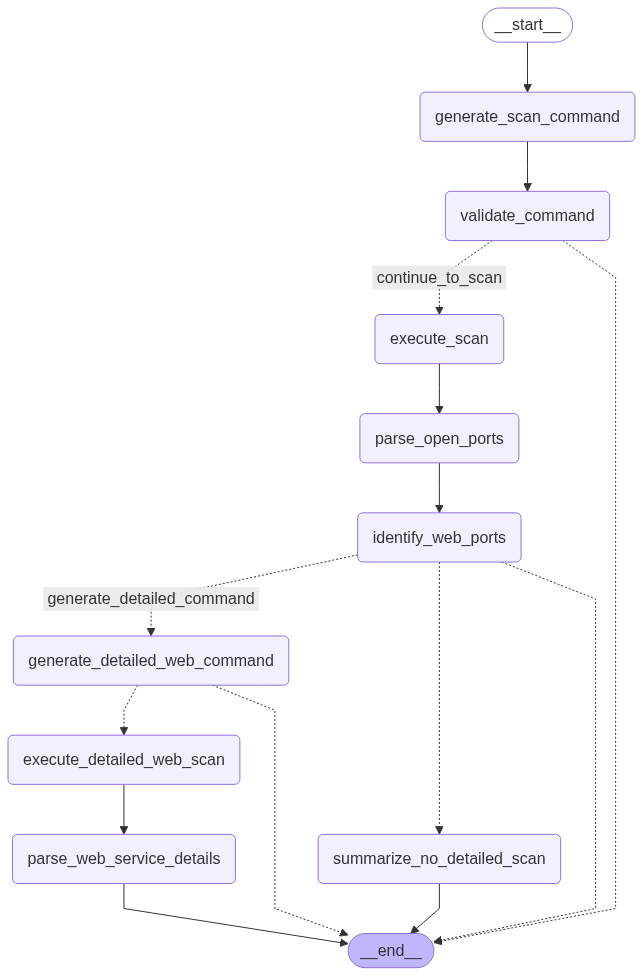

✅ Mermaid graph displayed.


In [80]:
# --- Display graph (optional, if in a Jupyter environment) ---
try:
    from IPython.display import Image, display
    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image, width=500))
    print("✅ Mermaid graph displayed.")
except ImportError:
    print("ℹ️ IPython not available, skipping graph display.")
    print("Mermaid graph definition:\n", app.get_graph().draw_mermaid())
except Exception as e:
    print(f"⚠️ Could not generate or display graph: {e}")

In [ ]:
# For testing, ensure Nmap is installed and accessible in your PATH.
# You can use "scanme.nmap.org" (be mindful of their scanning policies)
# or run local services, e.g., `python -m http.server 8000` and `python -m http.server 8080`

target_ip_to_scan = "127.0.0.1" 
# target_ip_to_scan = "scanme.nmap.org"


print(f"\n--- Starting Nmap Scan Workflow for Target: {target_ip_to_scan} ---")

initial_state = PortScanState(
    target_ip=target_ip_to_scan,
    scan_intent="Perform a fast scan for open TCP ports. If common web ports are found, conduct a detailed version and script scan on them.",
    llm_command_raw=None,
    validated_command=None,
    scan_output=None,
    open_ports=[],
    web_ports_identified=[],
    detailed_web_scan_command=None,
    detailed_web_scan_output=None,
    web_service_details=[],
    error_message=None
)

config = {"recursion_limit": 20} 

final_result = None
try:
    # Stream events to see the flow (optional)
    # for event_part in app.stream(initial_state, config=config):
    #     print(f"\n--- Event --- \n{list(event_part.keys())[0]}:\n{list(event_part.values())[0]}")
    #     if END in event_part:
    #         final_result = event_part[END]
    # if not final_result: # If streaming didn't capture END properly or wasn't used
    #     final_result = app.invoke(initial_state, config=config)
    
    final_result = app.invoke(initial_state, config=config)

except Exception as e:
    print(f"\n--- 💥 Workflow execution error ---")
    print(f"An unexpected error occurred during graph invocation: {e}")
    # You might want to inspect the state if possible or log more details.
    # final_result could be partially populated or None.

print("\n\n--- 🧾 Final Workflow State & Results ---")
if final_result:
    print(f"Target IP: {final_result.get('target_ip')}")
    
    if final_result.get('error_message'):
        print(f"⚠️ Workflow ended with an error: {final_result['error_message']}")
    else:
        print("✅ Workflow completed (or reached a planned end point).")

    print("\n--- Initial Scan Details ---")
    print(f"LLM Generated Initial Command: {final_result.get('llm_command_raw', 'N/A')}")
    print(f"Validated Initial Command: {final_result.get('validated_command', 'N/A')}")
    raw_initial_output = final_result.get('scan_output', 'N/A')
    if raw_initial_output and raw_initial_output != 'N/A':
        print(f"Initial Scan Output Snippet:\n{raw_initial_output[:300]}...\n")
    else:
        print(f"Initial Scan Output: {raw_initial_output}")
    print(f"All Open TCP Ports Found: {final_result.get('open_ports', 'N/A')}")

    print("\n--- Detailed Web Scan Details ---")
    print(f"Web Ports Identified for Detailed Scan: {final_result.get('web_ports_identified', 'N/A')}")
    print(f"Detailed Web Scan Command: {final_result.get('detailed_web_scan_command', 'N/A')}")
    
    raw_detailed_output = final_result.get('detailed_web_scan_output')
    if raw_detailed_output:
        print(f"Detailed Web Scan Output Snippet:\n{raw_detailed_output[:500]}...\n")
    elif final_result.get('detailed_web_scan_command'): # If command was set but no output
        print("Detailed Web Scan Output: No output captured or scan did not run successfully.")
    else:
        print("Detailed Web Scan Output: N/A (scan likely not performed)")

    print("\n--- 💎 Identified Web Service Details (from Detailed Scan) ---")
    web_services = final_result.get("web_service_details")
    if web_services:
        for service_info in web_services:
            print(f"  Port: {service_info['port']}, Service: {service_info['service']}, Version: {service_info['version']}")
    elif final_result.get("detailed_web_scan_command"): # If detailed scan was attempted
            print("  No specific web services parsed from detailed scan, or an error occurred during parsing.")
    else:
        print("  Detailed web scan was not performed or did not yield parsable results.")
else:
    print("❌ Workflow did not produce a final result dictionary (invocation might have failed critically).")



--- Starting Nmap Scan Workflow for Target: 127.0.0.1 ---
🔧 Generating fast scan command...
🔒 Validating generated command...
✅ Initial command validated successfully.
🚀 Executing initial scan: nmap -T4 -Pn -p- 127.0.0.1 -sV --version-light
🧠 Parsing open ports from initial scan...
Found open TCP ports: [8000, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9015, 9016, 9017, 9018, 9019, 33603, 35105, 40237]
🤖 Using LLM to identify web-related ports from scan_output...
Passing the following to LLM for web port identification:
8000/tcp: http
9000/tcp: zmtp
9001/tcp: zmtp
9002/tcp: zmtp
9003/tcp: zmtp
9004/tcp: zmtp
9005/tcp: zmtp
9006/tcp: zmtp
9007/tcp: zmtp
9008/tcp: zmtp
9009/tcp: zmtp
9015/tcp: zmtp
9016/tcp: zmtp
9017/tcp: zmtp
9018/tcp: zmtp
9019/tcp: zmtp
33603/tcp: zmtp
35105/tcp: zmtp
40237/tcp: zmtp
LLM response for web ports: '8000'
LLM identified web-related ports: [8000]
✅ Web ports identified: [8000]. Proceeding to generate detailed command.
📜 Generating detail